1. Limpieza y carga de Datos:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')


## SE DIVIDE CADA SECCION DEL EJERCICIO EN FUNCIONES PARA MEJORAR LA LEGIBILIDAD DEL CODIGO

def cargar_datos():
    train = pd.read_csv('../../../data/house-prices-advanced/train.csv')
    test = pd.read_csv('../../../data/house-prices-advanced/test.csv')
    return train, test

def limpieza_datos(df):
    # Eliminar duplicados
    df = df.drop_duplicates()

    # Convertir tipos de datos
    numericas = df.select_dtypes(include=['int64', 'float64']).columns
    categoricas = df.select_dtypes(include=['object']).columns

    # Manejo de valores faltantes imputando con SimpleImputer
    imputer_num = SimpleImputer(strategy='median')
    imputer_cat = SimpleImputer(strategy='most_frequent')

    df[numericas] = imputer_num.fit_transform(df[numericas])
    df[categoricas] = imputer_cat.fit_transform(df[categoricas])

    # Codificación de variables categóricas
    le = LabelEncoder()
    for col in categoricas:
        df[col] = le.fit_transform(df[col].astype(str))

    return df



def entrenamiento_evaluacion_modelos2(X_train, X_test, y_train, y_test):
    # Regresión Lineal
    print("Entrenando modelo de Regresión Lineal...")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_rmse = np.sqrt(lr_mse)
    lr_r2 = r2_score(y_test, lr_pred)
    
    # LightGBM
    print("Entrenando modelo de LightGBM...")
    lgbm = lgb.LGBMRegressor()
    lgbm.fit(X_train, y_train)
    lgbm_pred = lgbm.predict(X_test)
    lgbm_mse = mean_squared_error(y_test, lgbm_pred)
    lgbm_rmse = np.sqrt(lgbm_mse)
    lgbm_r2 = r2_score(y_test, lgbm_pred)
    
    # Explicación detallada de los resultados
    print("\nResultados detallados de los modelos:")
    print("\nRegresión Lineal:")
    print(f"- RMSE: {lr_rmse:.2f} (Raíz del error cuadrático medio: mide la magnitud promedio de los errores)")
    print(f"- R2: {lr_r2:.2f} (Coeficiente de determinación: mide qué proporción de la variabilidad de los datos explica el modelo)")

    print("\nLightGBM:")
    print(f"- RMSE: {lgbm_rmse:.2f} (Raíz del error cuadrático medio: mide la magnitud promedio de los errores)")
    print(f"- R2: {lgbm_r2:.2f} (Coeficiente de determinación: mide qué proporción de la variabilidad de los datos explica el modelo)")
    
    # Comparación y observaciones
    print("\nComparación de modelos:")
    if lr_rmse < lgbm_rmse:
        print(f"La Regresión Lineal tiene un RMSE menor ({lr_rmse:.2f}) que LightGBM ({lgbm_rmse:.2f}), lo que indica que predice con mayor precisión.")
    else:
        print(f"LightGBM tiene un RMSE menor ({lgbm_rmse:.2f}) que la Regresión Lineal ({lr_rmse:.2f}), lo que indica que predice con mayor precisión.")

    if lr_r2 > lgbm_r2:
        print(f"La Regresión Lineal tiene un R2 mayor ({lr_r2:.2f}) que LightGBM ({lgbm_r2:.2f}), lo que indica que explica mejor la variabilidad de los datos.")
    else:
        print(f"LightGBM tiene un R2 mayor ({lgbm_r2:.2f}) que la Regresión Lineal ({lr_r2:.2f}), lo que indica que explica mejor la variabilidad de los datos.")

    
    return lr, lgbm

def analisis_expl(train_df, test_df):
        # Variables más relevantes para el análisis
    variables_numericas = ['OverallQual', 'GrLivArea', 'YearBuilt', 'TotalBsmtSF']
    variables_categoricas = ['MSZoning', 'BldgType']
    
    # 1. Estadísticas descriptivas
    print("\nEstadísticas descriptivas - Conjunto de Entrenamiento:")
    print(train_df[variables_numericas].describe())
    print("\nEstadísticas descriptivas - Conjunto de Prueba:")
    print(test_df[variables_numericas].describe())
    
    # 2. Visualizaciones
    # 2.1 Distribuciones de variables numéricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparación de Distribuciones - Variables Numéricas', fontsize=16)
    
    for idx, var in enumerate(variables_numericas):
        i, j = divmod(idx, 2)
        
        # Histograma para train
        axes[i,j].hist(train_df[var], bins=30, alpha=0.5, label='Train', density=True)
        # Histograma para test
        axes[i,j].hist(test_df[var], bins=30, alpha=0.5, label='Test', density=True)
        
        axes[i,j].set_title(f'Distribución de {var}')
        axes[i,j].legend()
        axes[i,j].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 2.2 Análisis de variables categóricas
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Comparación de Distribuciones - Variables Categóricas', fontsize=16)
    
    for idx, var in enumerate(variables_categoricas):
        # Calcular porcentajes para cada conjunto
        train_pcts = train_df[var].value_counts(normalize=True) * 100
        test_pcts = test_df[var].value_counts(normalize=True) * 100
        
        # Crear DataFrame para comparación
        comp_df = pd.DataFrame({
            'Train': train_pcts,
            'Test': test_pcts
        }).fillna(0)
        
        comp_df.plot(kind='bar', ax=axes[idx])
        axes[idx].set_title(f'Distribución de {var}')
        axes[idx].set_ylabel('Porcentaje')
        axes[idx].grid(True)
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 3. Análisis de valores faltantes
    def missing_analysis(df, name):
        missing = df.isnull().sum()
        missing_pct = (missing / len(df) * 100)
        missing_df = pd.DataFrame({
            'Valores Faltantes': missing,
            'Porcentaje': missing_pct
        })
        missing_df = missing_df[missing_df['Valores Faltantes'] > 0].sort_values('Porcentaje', ascending=False)
        
        print(f"\nAnálisis de valores faltantes - {name}:")
        print(missing_df)
        return missing_df
    
    train_missing = missing_analysis(train_df, "Train")
    test_missing = missing_analysis(test_df, "Test")
    
    # 4. Análisis de correlaciones para variables numéricas
    train_corr = train_df[variables_numericas].corr()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(train_corr, cmap='coolwarm', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(variables_numericas)), variables_numericas, rotation=45)
    plt.yticks(range(len(variables_numericas)), variables_numericas)
    plt.title('Matriz de Correlación - Variables Numéricas (Train)')
    
    # Añadir valores numéricos
    for i in range(len(variables_numericas)):
        for j in range(len(variables_numericas)):
            plt.text(j, i, f"{train_corr.iloc[i, j]:.2f}", 
                    ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Resumen de hallazgos importantes
    print("\nResumen de hallazgos importantes:")
    
    # Comparar medias de variables numéricas
    print("\nComparación de medias entre Train y Test:")
    comparison_df = pd.DataFrame({
        'Train_Mean': train_df[variables_numericas].mean(),
        'Test_Mean': test_df[variables_numericas].mean(),
        'Diferencia_%': ((test_df[variables_numericas].mean() - train_df[variables_numericas].mean()) / 
                        train_df[variables_numericas].mean() * 100)
    })
    print(comparison_df)
    
    # Detectar valores atípicos
    def detect_outliers(df, variables):
        outliers = {}
        for var in variables:
            Q1 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
            outliers[var] = len(df[(df[var] < (Q1 - 1.5 * IQR)) | (df[var] > (Q3 + 1.5 * IQR))])
        return outliers
    
    print("\nCantidad de valores atípicos en Train:")
    print(detect_outliers(train_df, variables_numericas))
    print("\nCantidad de valores atípicos en Test:")
    print(detect_outliers(test_df, variables_numericas))



1. Limpieza de datos

In [6]:
train, test = cargar_datos()

train_limpio = limpieza_datos(train.copy())
test_limpio = limpieza_datos(test.copy())


2. Exploracion de datos


Estadísticas descriptivas - Conjunto de Entrenamiento:
       OverallQual    GrLivArea    YearBuilt  TotalBsmtSF
count  1460.000000  1460.000000  1460.000000  1460.000000
mean      6.099315  1515.463699  1971.267808  1057.429452
std       1.382997   525.480383    30.202904   438.705324
min       1.000000   334.000000  1872.000000     0.000000
25%       5.000000  1129.500000  1954.000000   795.750000
50%       6.000000  1464.000000  1973.000000   991.500000
75%       7.000000  1776.750000  2000.000000  1298.250000
max      10.000000  5642.000000  2010.000000  6110.000000

Estadísticas descriptivas - Conjunto de Prueba:
       OverallQual    GrLivArea    YearBuilt  TotalBsmtSF
count  1459.000000  1459.000000  1459.000000  1459.000000
mean      6.078821  1486.045922  1971.357779  1046.078136
std       1.436812   485.566099    30.390071   442.749327
min       1.000000   407.000000  1879.000000     0.000000
25%       5.000000  1117.500000  1953.000000   784.000000
50%       6.000000  1432.

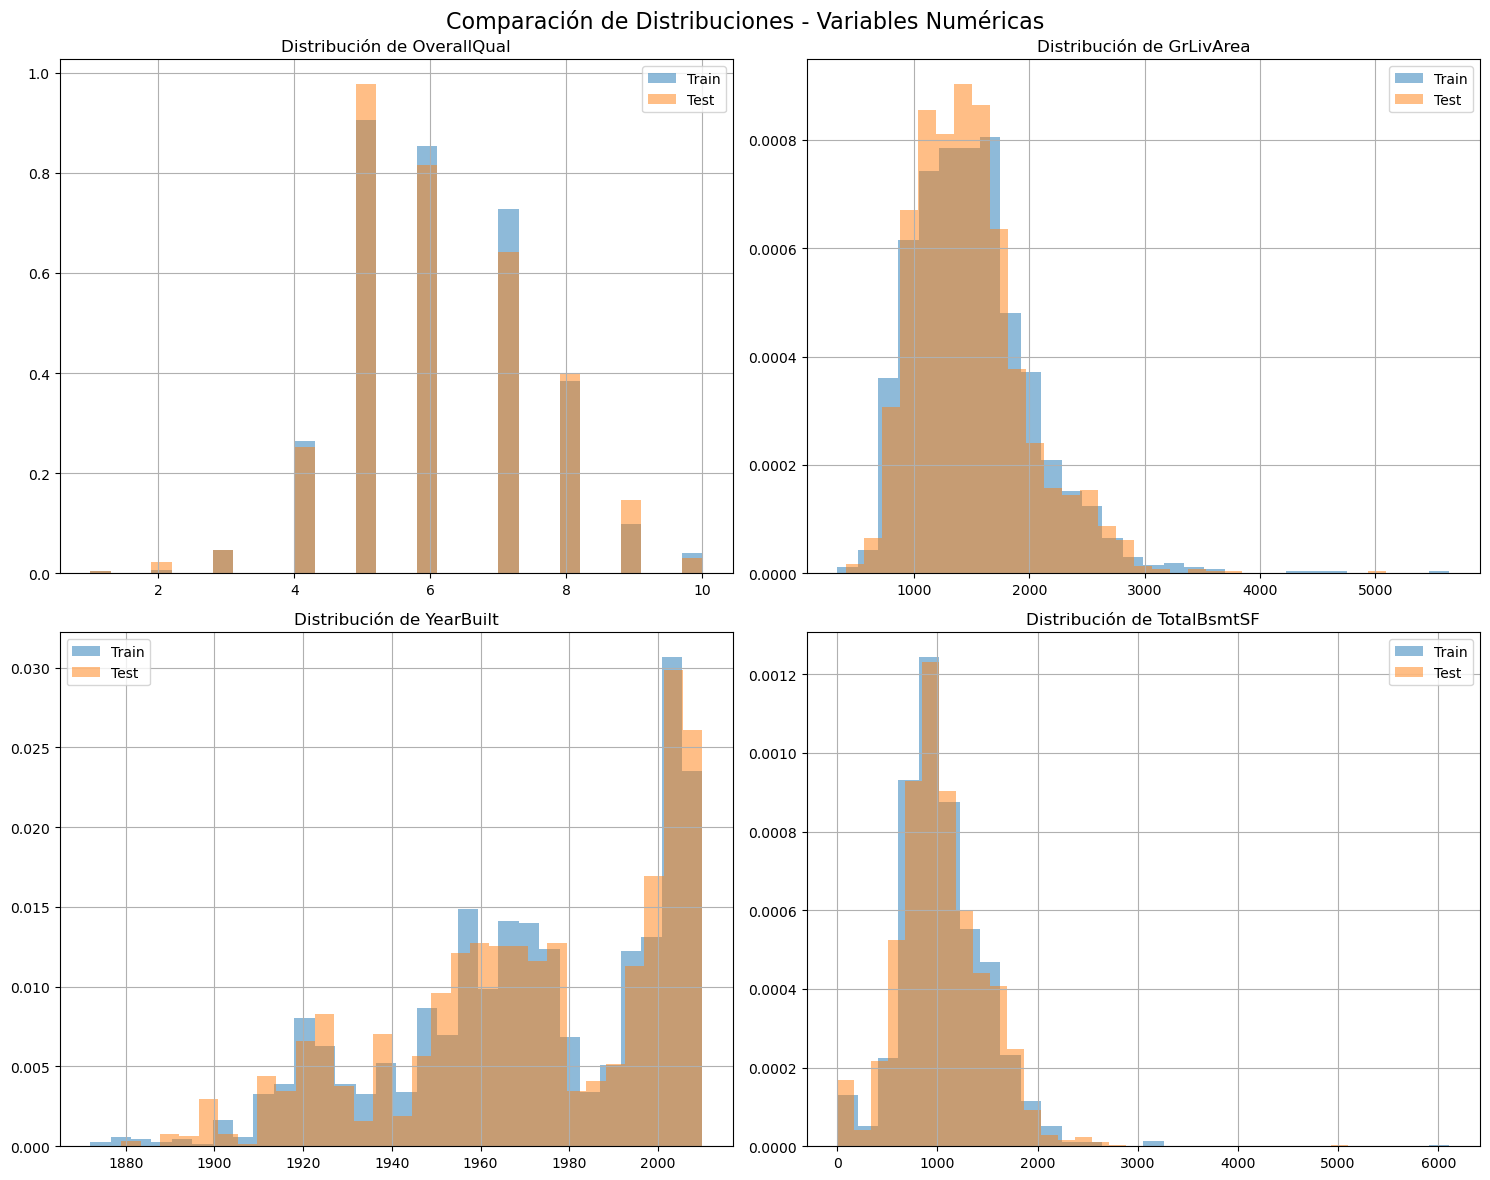

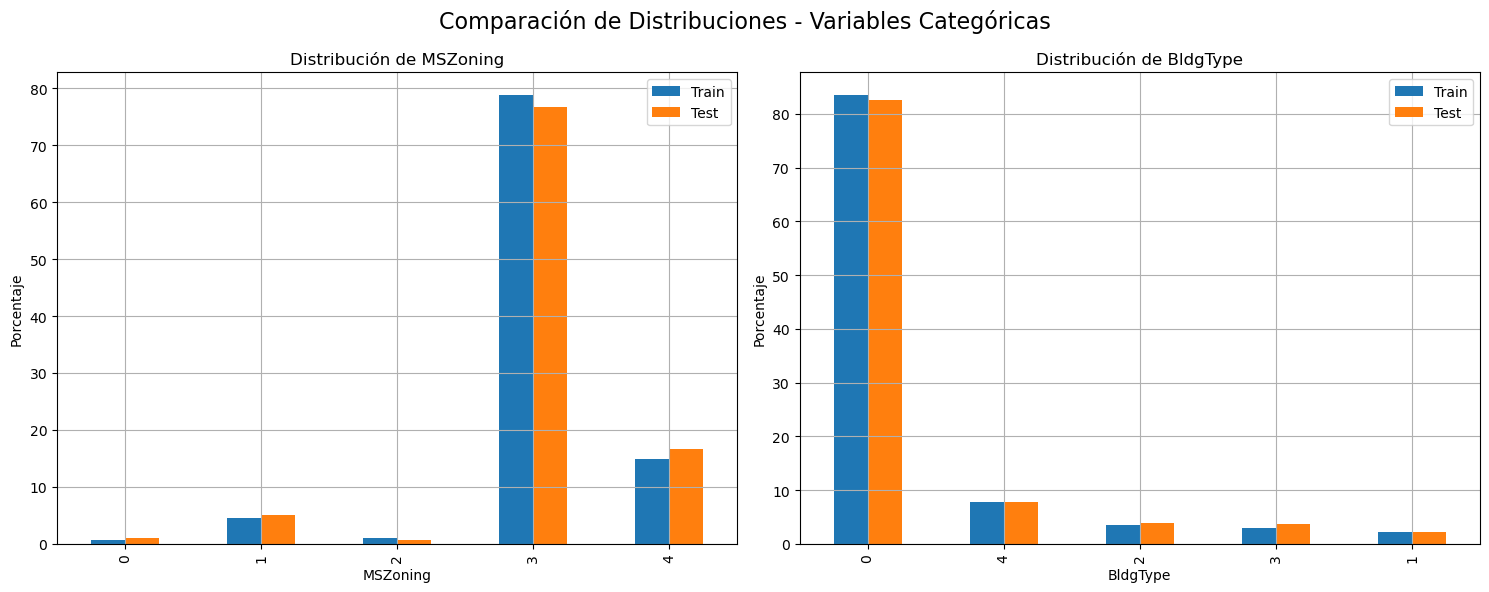


Análisis de valores faltantes - Train:
Empty DataFrame
Columns: [Valores Faltantes, Porcentaje]
Index: []

Análisis de valores faltantes - Test:
Empty DataFrame
Columns: [Valores Faltantes, Porcentaje]
Index: []


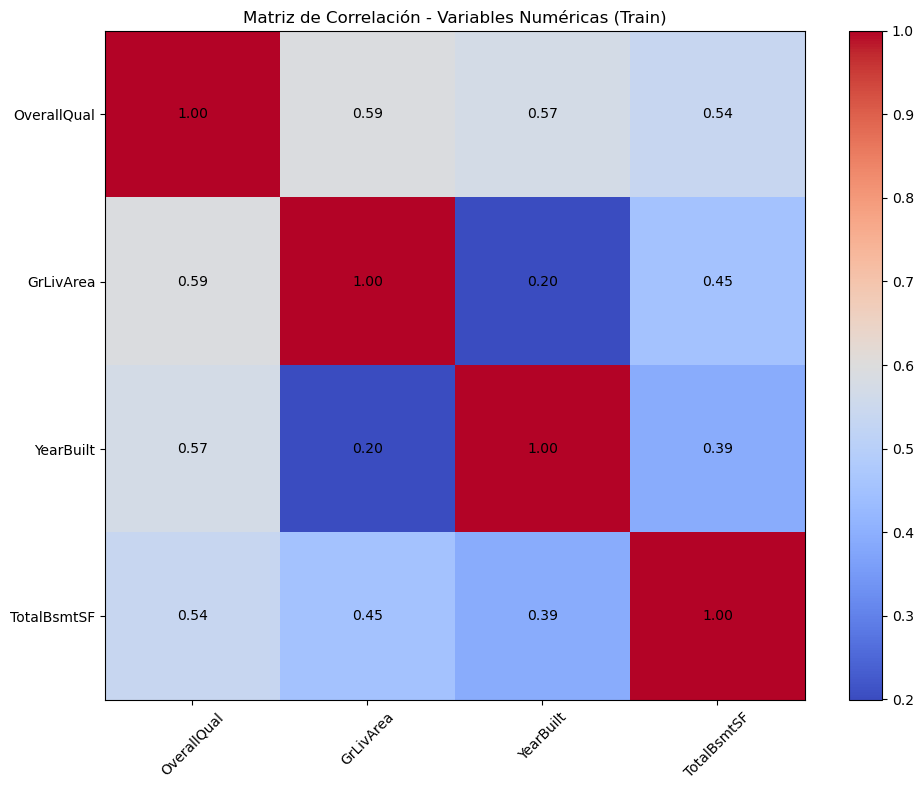


Resumen de hallazgos importantes:

Comparación de medias entre Train y Test:
              Train_Mean    Test_Mean  Diferencia_%
OverallQual     6.099315     6.078821     -0.336004
GrLivArea    1515.463699  1486.045922     -1.941173
YearBuilt    1971.267808  1971.357779      0.004564
TotalBsmtSF  1057.429452  1046.078136     -1.073482

Cantidad de valores atípicos en Train:
{'OverallQual': 2, 'GrLivArea': 31, 'YearBuilt': 7, 'TotalBsmtSF': 61}

Cantidad de valores atípicos en Test:
{'OverallQual': 2, 'GrLivArea': 44, 'YearBuilt': 2, 'TotalBsmtSF': 61}


In [7]:
analisis_expl(train_limpio, test_limpio)

* Observamos en los graficos usados para exploracion de datos, las diferencias que hay entre el set de pruebas y el de entrenamiento. Notamos que en ciertas variables si hay una diferencia apreciable, mientras que en otras, ambos sets son muy similares en cuanto a datos
* En la matriz de correlacion de los datos de entrenamiento, vemos que existe correlacion debil entre las variables numericas
* La distribucion de los datos entre ambos sets son bastante similares
* La cantidad de valores atipicos en test para la variable GrLivArea es mayor que en train
* Las variables GrLivArea, YearBuilt, y TotalBsmtSF tienen un número significativo de valores atípicos en ambos conjuntos (Train y Test).
* OverallQual tiene pocos valores atípicos, lo cual se encuentra dentro de lo aceptable

3. Implementacion de modelos

In [8]:
print("\nCorrida de modelos con set de entrenamiento\n")
X = train_limpio.drop(['Id', 'SalePrice'], axis=1)
y = train_limpio['SalePrice']

x2 = test_limpio.drop(['Id'], axis=1)
y2 = test_limpio

# División del conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar y evaluar modelos
lr_model, lgbm_model = entrenamiento_evaluacion_modelos2(X_train, X_test, y_train, y_test)


Entrenando modelo de Regresión Lineal...
Entrenando modelo de LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3109
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 72
[LightGBM] [Info] Start training from score 181441.541952

Resultados detallados de los modelos:

Regresión Lineal:
- RMSE: 35312.14 (Raíz del error cuadrático medio: mide la magnitud promedio de los errores)
- R2: 0.84 (Coeficiente de determinación: mide qué proporción de la variabilidad de los datos explica el modelo)

LightGBM:
- RMSE: 29207.68 (Raíz del error cuadrático medio: mide la magnitud promedio de los errores)
- R2: 0.89 (Coeficiente de determinación: mide qué proporción de la variabilidad de los datos explica el modelo)

Comparación de modelos:
LightGBM t

Para este dataset y con los datos de entrenamienot, se observa que el modelo LightGBM obtuvo mejores resultados, siendo el error cuadratico medio solo del 29% sobre el 35% de la regresion lineal, tener en cuenta que LigthGBM requiere mas tiempo de entrenamiento y maneja mejor los datos limeales